In [40]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Dense, InputLayer, GRU, LSTM, Embedding, Bidirectional, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import os
import matplotlib.pyplot as plt

In [41]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Loading Data

In [42]:
sentences = []
with open('dataset.txt', 'r') as file:
    text = file.read()
    text = text.strip()
    lines = text.split('\n')
    for line in lines:
        if len(line) > 0:
            sentences.append(line)
print(len(sentences)) 

9566


# Tokenizing the data

In [43]:
sentences_to_consider = len(sentences)
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(sentences[:sentences_to_consider])
word_index = tokenizer.word_index
len(word_index)

8200

In [44]:
# Filtering the text to create n-ragged sequences
print(len(sentences[0]))

def remove_extra_characters(text):
    filtered_text = []
    for item in text:
        new_text = item.replace('_', ' ')
        new_text = new_text.replace('.', '')
        new_text = new_text.replace(',', '')
        new_text = new_text.replace('!', '')
        new_text = new_text.replace('$', '')
        new_text = new_text.replace('-', '')
        new_text = new_text.replace('(', '')
        new_text = new_text.replace(')', '')
        new_text = new_text.replace('  ', ' ')
        new_text = new_text.replace('“', '')
        new_text = new_text.replace('”', '')
        filtered_text.append(new_text)
    return filtered_text

filtered_sentences = remove_extra_characters(sentences)

print(len(filtered_sentences[0]))

33
33


In [45]:
# Tokenizing the sequence
sequences = tokenizer.texts_to_sequences(filtered_sentences)
n_ragged_sequences = []
sentences_count = 0
# Creating n-ragged sequences
for sequence in sequences:
    for i in range(len(sequence) - 1):
        new_sequence = sequence[0:i+2]
        n_ragged_sequences.append(new_sequence)
    sentences_count += 1
    if sentences_count >= sentences_to_consider:
        break
len(n_ragged_sequences)

95053

In [46]:
# Finding the max length
lengths = [len(seq) for seq in n_ragged_sequences]
max_n_ragged_len = max(lengths)
# Padding the sequences
padded_sequences = pad_sequences(n_ragged_sequences, padding='pre', maxlen=max_n_ragged_len)
padded_sequences = np.array(padded_sequences)
max_length = len(padded_sequences[0])
max_length

18

# Preparing the Dataset

In [47]:
X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]
y = to_categorical(y)
X.shape, y.shape

((95053, 17), (95053, 8201))

In [48]:
# Splitting the dataset in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [49]:
# Training and Testing Sizes
(len(X_train), len(y_train)), (len(X_test), len(y_test))

((85547, 85547), (9506, 9506))

# Defining the Model

In [50]:
num_labels = len(tokenizer.word_index) + 1
epochs = 100
batch_size = 1024
num_labels

8201

In [57]:
model = Sequential([
    Embedding(num_labels, 100, input_length=max_length - 1),
    Bidirectional(LSTM(150, return_sequences= True)),
    Bidirectional(LSTM(150)),
    Dropout(0.2),
    Dense(units= 1024, activation= 'relu'),
    Dropout(0.2),
    Dense(units= num_labels, activation= 'softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 17, 100)           820100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 17, 300)          301200    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              308224    
                                                                 
 dropout_5 (Dropout)         (None, 1024)             

In [58]:
checkpoint = ModelCheckpoint(filepath= 'predictor.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch', verbose=1)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test), validation_batch_size=64, callbacks=[checkpoint])

Epoch 1/100
1337/1337 [==============================] - ETA: 0s - loss: 6.2537 - accuracy: 0.0663
Epoch 1: val_loss improved from inf to 5.96107, saving model to predictor.h5
1337/1337 [==============================] - 233s 168ms/step - loss: 6.2537 - accuracy: 0.0663 - val_loss: 5.9611 - val_accuracy: 0.0876
Epoch 2/100
1337/1337 [==============================] - ETA: 0s - loss: 5.7323 - accuracy: 0.0983
Epoch 2: val_loss improved from 5.96107 to 5.77708, saving model to predictor.h5
1337/1337 [==============================] - 223s 166ms/step - loss: 5.7323 - accuracy: 0.0983 - val_loss: 5.7771 - val_accuracy: 0.1117
Epoch 3/100
1337/1337 [==============================] - ETA: 0s - loss: 5.4539 - accuracy: 0.1189
Epoch 3: val_loss improved from 5.77708 to 5.73100, saving model to predictor.h5
1337/1337 [==============================] - 232s 173ms/step - loss: 5.4539 - accuracy: 0.1189 - val_loss: 5.7310 - val_accuracy: 0.1250
Epoch 4/100
1337/1337 [==============================

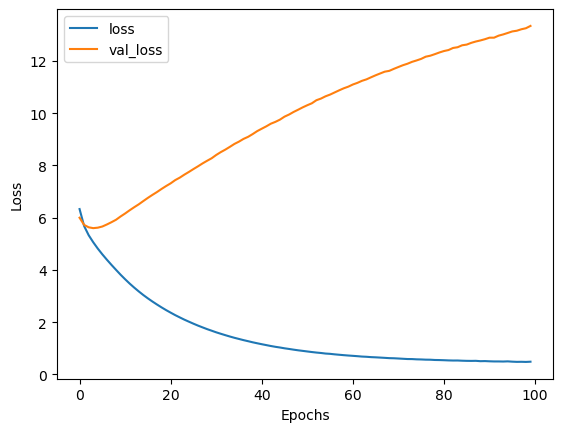

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

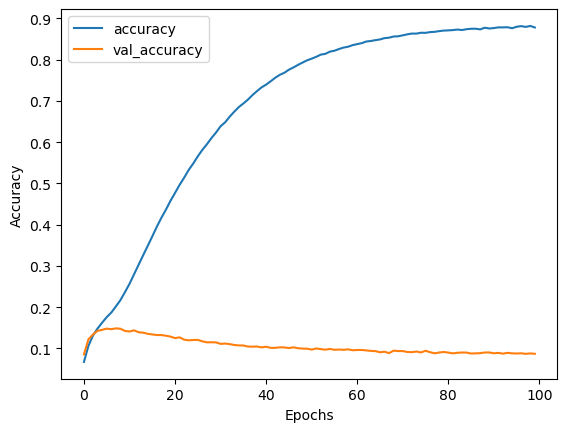

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])